# Tutorial of Fairness Metrics for Healthcare ML

### Overview
This tutorial introduces methods and libraries for measuring fairness and bias in machine learning models as as they relate to problems in healthcare. Through the tutorial you will first learn some basic background about fairness and bias in machine learning. You will then generate a simple baseline model predicting Length of Stay (LOS) using data from the [MIMIC-III database](https://mimic.physionet.org/gettingstarted/access/), which you will use as an example to understand the most prominent fairness measures. You will also gain familiarity with the Scikit-Learn-compatible tools available in [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/), two of the most comprehensive and flexible Python libraries for measuring and addressing bias in machine learning models.
  
### Tutorial Contents
[Part 0](#part0) - Fairness and Bias Background

[Part 1](#part1) - Model Setup

[Part 2](#part2) - Metrics of Fairness in AIF360

[Part 3](#part3) - Comparing Against a Second Model: Evaluating Unawarenes

[Part 4](#part4) - Testing Other Sensitive Attributes

[Part 5](#part5) - Comparison to FairLearn

### Tutorial Requirements
This tutorial assumes basic knowledge of machine learning implementation in Python. Before starting, please install [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/). Also, ensure that you have installed the Pandas, Numpy, Scikit, and XGBOOST libraries.

The tutorial also uses data from the MIMIC III Critical Care database, a freely accessible source of Electronic Health Records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/). Please save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location: you do not need to unzip any files.

## Part 0 - Fairness and Bias Background <a class="anchor" id="part0"></a>

There are six common definitions of fairness in machine learning models (aka. "metrics" of fairness): Equal Treatment ("Unawareness"), Demographic Parity, Equalized Odds, Predictive Parity, Individual Fairness, and Counterfactual Fairness. [Part 2](#part2) of this tutorial will provide basic definitions and guide you through different techniques for measuring these metrics using [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/). Note that this tutorial will not elaborate the details of counterfactual fairness since the libraries used do not have built-in functionality for it.


## Quick Reference of Fairness Metrics


| Metric | Defintion | Weakness | References |
|------|------|------|------|
| Unawareness | A model is unaware if the sensitive attribute is not used. | Removal of a sensitive attribute may be ineffectual due to the presence of proxy features highly correlated with the sensitive attribute. | [Zemel *et al* (2013)](#zemel2013_ref), [Barocas and Selbst (2016)](#barocas2016_ref) |
| Demographic Parity | A model has demographic parity if the predicted positve rates (selection rates) are approximately the same for all sensitive attribute groups.<br> P(ŷ =1 \| unprivileged) / P(ŷ =1 \| privileged) | Historical biases present in the data are not addressed and may still bias the model. | [Zafar *et al* (2017)](#zafar2017_ref) |
| Equalized Odds | Odds are equalized if P(+) is approximately the same for all sensitive attribute groups.<br>  **Equal Opportunity** is a special case of equalized odds specifying that P(+\|y=1) is approximately the same across groups. | Historical biases present in the data  are not addressed and may still bias the model. | [Hardt *et al* (2016)](#hardt2016_ref) |
| Predictive Parity | Predictive parity exists where the Positive Predictive Value and Negative Predictive Value are each approximately the same for all sensitive attribute groups. | Historical biases present in the data are not addressed and may still bias the model.  | [Zafar *et al* (2017)](#zafar2017_ref) |
| Individual Fairness | Individual fairness exists if "similar" individuals (ignoring the sensitive attribute) are likely to have similar predictions. | The appropriate metric for similarity may be ambiguous. |[Dwork (2012)](#dwork2012_ref), [Kim *et al* (2018)](#kim2018_ref) |
| Counterfactual Fairness | Counterfactual fairness exists where counterfactual replacement of the sensitive attribute does not significantly alter predictive performance. This counterfactual change must be propogated to correlated variables. | It may be intractable to develop a counterfactual model.  | [Russell *et al* (2017)](#russell2017_ref) |


## Part 1 - Model Setup <a class="anchor" id="part1"></a>

This section introduces and loads the data subset that will be used in this tutorial. We will use it to generate a simple baseline model that will be used throughout the tutorial.

In [276]:
# Standard Libraries
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

# Prediction Libraries
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

# Metrics
import sklearn.metrics as sk_metrics
from aif360.sklearn.metrics import *
from fairlearn.metrics import (
    selection_rate as fairlearn_selection_rate, 
    demographic_parity_difference, demographic_parity_ratio,
    balanced_accuracy_score_group_summary, roc_auc_score_group_summary,
    equalized_odds_difference, equalized_odds_ratio,
    difference_from_summary)

# Helpers from local folder
import tutorial_helpers

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed


## Loading MIMIC III Data
As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [159]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [270]:
df = tutorial_helpers.load_example_data(path_to_mimic_data_folder) 
print(f"\n Our data subset has {df.shape[0]} total observations and {df.shape[1]-2} input features \n")
df.head()


 Our data subset has 22434 total observations and 648 input features 



,ADMIT_ID,AGE,length_of_stay,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS

## Baseline Length of Stay Model
The example models in this tutorial predict the total length of time spent in the Intensive Care Unity (ICU) for a given hospital admission, a.k.a. the "Length of Stay" (LOS). The baseline model will use only the patient's age, their diagnosis, and the use of medical procedures during their stay to predict this value. 

Two target variables will be used in the following experiments: 'length_of_stay' and 'long_los'. The length_of_stay target contains the true value in days for the patient's stay in ICU. The long_los target is a binary variable indicating whether or not the length_of_stay for a given admission is greater than the mean. We will generate variable below, then generate our baseline model.

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.0,9.1152,6.2087,0.0042,4.7352,7.5799,12.0177,29.9889
long_los,22434.0,0.3880,0.4873,0.0000,0.0000,0.0000,1.0000,1.0000


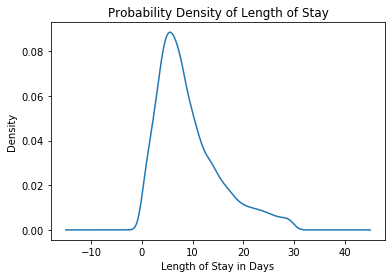

In [191]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
display(df[['length_of_stay', 'long_los']].describe().transpose().round(4))

# Display LOS distributions
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()


In [147]:
# Subset and Split Data
X = df.loc[:,[c for c in df.columns if (c.startswith('AGE') or c.startswith('DIAGNOSIS_') or c.startswith('PROCEDURE_'))]]
y = df.loc[:, ['long_los']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 5, 
                'min_child_weight': 1,  'n_estimators': 600, 'subsample': 0.6}

# Train Model
baseline_model = XGBClassifier(**xgb_params)
baseline_model.fit(X_train, y_train.iloc[:,0])
baseline_y_pred = baseline_model.predict(X_test)
baseline_y_prob = baseline_model.predict_proba(X_test)

print("\n", "Prediction Scores for Baseline Model:", "\n", sk_metrics.classification_report(y_test.iloc[:,0], baseline_y_pred), target_names=['LOS <= mean', 'LOS > mean']) )


 Baseline Scores: 
               precision    recall  (f1) score   support

           0       0.79      0.88      0.83      4531
           1       0.77      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404



## Part 2 - Testing Gender as a Sensitive Attribute <a class="anchor" id="part2"></a>
Our first experiment will test the effect of including the sensitive attribute 'GENDER_M'. This attribute is encoded in our data as a boolean attribute, where 0=female and 1=male, since males are assumed to be the privileged group. For the purposes of this experiment all other senstitive attributes and potential proxies will be dropped, such that only gender, age, diangosis, and procedure codes will be used to make the prediction.

First we will examine fairness measurements for a version of this model that includes gender as a feature, before comparing them to similar measurements for the baseline (without gender). We will see that while some measures can be used to analyze a model in isolation, others (e.g. Unawareness) require comparison against other models to clearly demonstrate a model's fairness/unfairness.

In [10]:
df.groupby('GENDER_M')['length_of_stay'].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
GENDER_M,,,,,,,,
0,9987.0,9.1373,6.1984,0.0042,4.7507,7.6722,12.0667,29.9889
1,12447.0,9.0975,6.2171,0.0049,4.7149,7.4597,11.9729,29.9660


In [11]:
# Update Split Data to Include Gender as a Feature
X_train_gender = X_train.join(df[['GENDER_M']], how='inner')
X_test_gender = X_test.join(df[['GENDER_M']], how='inner')

# Train New Model with Gender Feature
gender_model = XGBClassifier()
gender_model.fit(X_train_gender, y_train.iloc[:,0])
y_pred_gender = gender_model.predict(X_test_gender)
y_prob_gender = gender_model.predict_proba(X_test_gender)

print("\n", "Prediction Scores for Model with Gender Included:", "\n", sk_metrics.classification_report(y_test.iloc[:,0], y_pred_gender, target_names=['LOS <= mean', 'LOS > mean']) )


 Scores for Model with Gender Included: 
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      4531
           1       0.77      0.54      0.63      2873

    accuracy                           0.76      7404
   macro avg       0.76      0.72      0.73      7404
weighted avg       0.76      0.76      0.75      7404



## Measuring Fairness via AIF360

**Note:** AIF360 requires the sensitive attribute(s) to be the index of the dataframes (or 2-D arrays) containing the ground truth and the prediction targets. For our walkthrough of the different measures we will add that formatting in the cell below. Note that Dataframes that have been formatted for the AIF360 Scikit API will be given the suffix "_aif".


In [12]:
# Generate target dataframes specifically formatted as inputs for AIF360
y_test_aif = pd.concat([X_test_gender['GENDER_M'], y_test], axis=1).set_index('GENDER_M')
y_pred_aif = pd.concat([X_test_gender['GENDER_M'].reset_index(drop=True), pd.Series(y_pred_gender)], axis=1).set_index('GENDER_M')
y_pred_aif.columns = y_test_aif.columns


### Prediction Rates
Since the effect of Unawareness is difficult to measure without comparison against another model, we will begin our exploration of AIF360 by demonstrating some common terminology. For the curious, Unawareness will be dissused in [Part 3](#part3). 

The *Base Rate* returns the average value of the ground truth (optionally weighted). It provides useful context, although it is not technically a measure of fairness. 
> $base\_rate = \sum_{i=0}^N(y_i)/N$

The *Selection Rate* returns the average predicted value. For a binary prediction problem it equates to the probability of prediction for the positive class ("the probability of selection").
> $selection\_rate = \sum_{i=0}^N(ŷ_i)/N$

In [247]:
# Demonstrate that the Base Rate and Selection Rate return mean values
print("base_rate = ", base_rate(y_test_aif),
      "\n\tP(y_+) =", y_test_aif['long_los'].mean()
     )
print('overall selection_rate =', selection_rate(y_test_aif, y_pred_aif),
      "\n\tP(ŷ_+) =", y_pred_aif['long_los'].mean()
     )

# Display the group-specific selection rates
females = (y_pred_aif.index.get_level_values('GENDER_M') == 0)
print()
print('Selection rate for the unprivileged group =', y_pred_aif.loc[females, 'long_los'].mean())
print('Selection rate for the privileged group =', y_pred_aif.loc[~females, 'long_los'].mean())


base_rate =  0.3880334954078876 
	P(y_+) = 0.3880334954078876
selection_rate = 0.27188006482982174 
	P(ŷ_+) = 0.27188006482982174

Selection rate for the unprivileged group = 0.27545651501083257
Selection rate for the privileged group = 0.26911095135394203


### Measures of Demographic Parity
A model has demographic parity if the predicted positve rates (selection rates) are approximately the same for all sensitive attribute groups. Two common measures for demographic parity are the Statistical Parity Difference and the Disparate Impact Ratio.

The *Statistical Parity Difference* is the difference in the probability of prediction between the two groups. A difference of 0 indicates that the model is fair relative to the sensitive attribute (it favors neither the privileged nor the unprivileged group).
> $statistical\_parity\_difference = P(ŷ =1 | unprivileged) - P(ŷ =1 | privileged) $

The *Disparate Impact Ratio* is the ratio between the probability of positive prediction for the unprivileged group and the probability of positive prediction for the privileged group. A ratio of 1 indicates that the model is fair relative to the sensitive attribute (it favors neither the privileged nor the unprivileged group).
> $disparate\_impact\_ratio = \dfrac{P(ŷ =1 | unprivileged)}{P(ŷ =1 | privileged)} = \dfrac{selection\_rate(ŷ_{unprivileged})}{selection\_rate(ŷ_{privileged})}$


In [248]:
# Display the Disparate Impact Ratio and Statistical Parity Difference
print('disparate_impact_ratio \n', '\t', 
      disparate_impact_ratio(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )
print('statistical_parity_difference \n', '\t', 
      statistical_parity_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )


disparate_impact_ratio 	 1.023579730311847
statistical_parity_difference 	 0.0063455636568905405


### Measures of Equal Odds
Odds are equalized if P(+) is approximately the same for all sensitive attribute groups.

*Average Odds Difference* measures the average of the difference in False Positive Rate (FPR) and True Positive Rate (TPR) for the unprivileged and privileged groups. A difference of 1 indicates that the model is fair relative to the sensitive attribute.
> $ average\_odds\_difference = \dfrac{(FPR_{unprivileged} - FPR_{privileged})
        + (TPR_{unprivileged} - TPR_{privileged})}{2}$

*Average Odds Error* is the average of the absolute difference in FPR and TPR for the unprivileged and privileged groups. A difference of 1 indicates that the model is fair relative to the sensitive attribute.
> $average\_odds\_error = \dfrac{|FPR_{unprivileged} - FPR_{privileged}|
        + |TPR_{unprivileged} - TPR_{privileged}|}{2}$
        
*Equal Opportunity Difference* is the difference in recall scores (TPR) between the unprivileged and privileged groups. A difference of 0 indicates that the model is fair relative to the sensitive attribute.
> $equal\_opportunity\_difference =  Recall(ŷ_{unprivileged}) - Recall(ŷ_{privileged})$


In [15]:
# Display measures of Equal Odds
print('average_odds_difference', '\t', 
       average_odds_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M'))
print('average_odds_error', '\t', 
       average_odds_error(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )
print('equal_opportunity_difference', '\t', 
       equal_opportunity_difference(y_test_aif, y_pred_aif, prot_attr='GENDER_M')
     )


average_odds_difference 	 0.00861739753377283
average_odds_error 	 0.010429743030873684
equal_opportunity_difference 	 0.019047140564646514


### Predictive Rate Parity and Disparate Performance
Predictive parity exists where the Positive Predictive Value and Negative Predictive Value are each approximately the same for all sensitive attribute groups.

The *Positive Predictive Paritiy Difference* is the difference in Positive Predictive Value (PPV), aka. the precision. 
> $positive\_predictive\_parity\_difference =  precision(ŷ_{unprivileged}) - precision(ŷ_{privileged})$

<a id='aif_difference_func'></a>
Although neither of the libraries in this tutorial have a specific function for measuring Predictive Parity, both libraries do include features for calculaing custom, between-group differences in performance. In AIF360, this is facilitated by a flexible "difference" method that accepts an arbitrary scoring function as an argument. AIF360 also contains a "ratio" function of similar purpose. Here we will use difference() and ratio() to calculate  positive predictive parity difference for the GENDER_M model, in addition to several different custom metrics.


In [252]:
# Display examples using the difference function
print('\n', 'Positive Predictive Parity Difference',
          difference(sk_metrics.precision_score, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1)
     )
print('\n', 'Between-Group AUC Difference',
          difference(sk_metrics.roc_auc_score, y_test_aif, y_prob_gender[:, 1], prot_attr='GENDER_M', priv_group=1)
     )
print('\n', 'Between-Group Balanced Accuracy Difference', 
          difference(sk_metrics.balanced_accuracy_score, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1)
     )

# Display examples using the ratio function
print('\n', 'Selection Rate Ratio (Disparate Impact Ratio)', 
        ratio(selection_rate, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1) 
     )
print('\n', 'Recall Ratio', 
        ratio(sk_metrics.recall_score, y_test_aif, y_pred_gender, prot_attr='GENDER_M', priv_group=1) 
     )



 Positive Predictive Parity Difference 0.009475021761533586

 Between-Group AUC Difference 	 -0.00042839809003625273

 Between-Group Balanced Accuracy Difference 	 0.010429743030873628

 Selection Rate Ratio (Disparate Impact Ratio) 1.023579730311847

 Recall Ratio 1.0358573495048404


### Measures Of Individual Fairness
Measures of individual fairness determine if "similar" individuals (ignoring the sensitive attribute) are likely to have similar predictions.

#### Consistency Scores
Consistency scores measure the similarity between a given prediction and the predictions of "like" individuals. In AIF360, the consistency score is calculated as the compliment of the mean distance to the score of the mean nearest neighbhor, using Scikit's Nearest Neighbors algorithm (default 5 neighbors determined by BallTree algorithm). For this measure, values closer to zero indicate greater fairness, with increasing values indicating decreased fairness. However, since this measure is dimensionless, its utility is only realized in comparison to other scores from similar models.
> $ consistency\_score = 1 - |mean_{distance}(mean({nearest\ neighbor}) )| $

#### The Generalized Entropy Index and Related Measures
The *Generalized Entropy (GE) Index* was originally proposed as a metric for income inequality ([Shorrocks 1980](#shorrocks_ref)), but originated as a measure of redundancy in information theory. In 2018, [Speicher *et al*](#speicher2018_ref) proposed its use for Machine Learning models.
> $ GE = \mathcal{E}(\alpha) = \begin{cases}
            \frac{1}{n \alpha (\alpha-1)}\sum_{i=1}^n\left[\left(\frac{b_i}{\mu}\right)^\alpha - 1\right],& \alpha \ne 0, 1,\\
            \frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu},& \alpha=1,\\
            -\frac{1}{n}\sum_{i=1}^n\ln\frac{b_{i}}{\mu},& \alpha=0.
        \end{cases}
        $

*Generalized Entropy Error* is the generalized entropy index of the prediction error. Like the consistency_score above, this measure is dimensionless and thus most useful in comparison between models. Values closer to zero indicate greater fairness and increasing values indicating decreased fairness. 
> $ GE(Error) = GE(\hat{y}_i - y_i + 1) $

*Between Group Generalized Entropy Error* is the generalized entropy index for the weighted means of group-specific errors. Again this measure is dimensionless, with values closer to zero indicate greater fairness and increasing values indicating decreased fairness. 
> $ GE(Error_{group}) =  GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $


In [17]:
print('\n', 'consistency_score',
      consistency_score(X_test_gender, y_pred_gender)
     )
print('\n', 'generalized_entropy_error', 
      generalized_entropy_error(y_test['long_los'], y_pred_gender)
     )
print('\n', 'between_group_generalized_entropy_error', 
      between_group_generalized_entropy_error(y_test_aif, y_pred_aif, prot_attr=['GENDER_M'])
     )

consistency_score 	 0.8304970286331712
generalized_entropy_error 	 0.14575895125567154
between_group_generalized_entropy_error 	 6.052742433084012e-06


### Quick Reference for Fairness Measures
| Metric | Measure | <div style="width:400px" align="center">Definition</div>  | Interpretation |
|----|----|----|----|
| **General Measures** | **Base Rate** | $\sum_{i=0}^N(y_i)/N$  |- |
| | **Selection Rate** | $\sum_{i=0}^N(ŷ_i)/N$ | - |
| **Group Fairness Measures** | **Demographic (Statistical) Parity Difference** | $P(ŷ =1 | unprivileged) - P(ŷ =1 | privileged) $| 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| | **Disparate Impact Ratio (Demographic Parity Ratio)** | $\dfrac{P(ŷ =1 | unprivileged)}{P(ŷ =1 | privileged)} = \dfrac{selection\_rate(ŷ_{unprivileged})}{selection\_rate(ŷ_{privileged})}$ | 1 indicates fairness <br>  < 1 favors privileged group <br>  > 1 favors unprivileged group |
| | **Generalized Between-Group Predictive Disparity (eg. difference in ROC)** | - |
| | **Average Odds Difference** | $\dfrac{(FPR_{unprivileged} - FPR_{privileged}) + (TPR_{unprivileged} - TPR_{privileged})}{2}$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| | **Average Odds Error** | $\dfrac{|FPR_{unprivileged} - FPR_{privileged}| + |TPR_{unprivileged} - TPR_{privileged}|}{2}$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| | **Equal Opportunity Difference** | $Recall(ŷ_{unprivileged}) - Recall(ŷ_{privileged})$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| | **Equalized Odds Difference** | $max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$ | 0 indicates fairness <br> (-) favors privileged group <br> (+) favors unprivileged group |
| | **Equalized Odds Ratio**** | $min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$ | 1 indicates fairness <br>  < 1 favors privileged group <br>  > 1 favors unprivileged group |
| **Individual Fairness Measures** | **Consistency Score** | $1 - |mean_{distance}(mean({nearest\ neighbor}) )$ | 0 indicates fairness<br>(+) indicates unfairness |
| | **Generalized Entropy Index** | - |
| | **Between-Group Generalized Entropy Error** | $GE(\hat{y}_i - y_i + 1) $ | 0 indicates fairness<br>(+) indicates unfairness |
| | **Generalized Entropy Error** | $GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $ | 0 indicates fairness<br>(+) indicates unfairness |

## Part 3 - Comparing Against a Second Model <a class="anchor" id="part3"></a>
### Evaluating Unawareness 
A model is unaware relative to a sensitive attribute so long as that attribute is not included in the model. 

To facilitate comparison between our GENDER_M-inclusive model and the baseline, this tutorial includes a helper function which returns all of the previously seen measures in a convenient pandas dataframe. This function will be used to save space for the remainder of the tutorial. 

Below we generate a table conatining fairness scores for our LOS models. The scores we just generated are constrasted against gender-relative scores for the baseline model, which importantly does not contain GENDER_M as an attribute. As the table shows, removal of the gender attribute produces little change in measure values. 

In [254]:
# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Gender-Included Model, Relative to Patient Gender
gender_scores = tutorial_helpers.get_aif360_measures_df(X_test_gender, y_test, y_pred_gender, y_prob_gender, sensitive_attributes=['GENDER_M'])

# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Baseline Model, Relative to Patient Gender
baseline_scores = tutorial_helpers.get_aif360_measures_df(X_test_gender, y_test, baseline_y_pred, baseline_y_prob, sensitive_attributes=['GENDER_M'])

# Merge Results to Compare Values
comparison = gender_scores.rename(columns={'value':'gender fairness'}
                                ).merge(baseline_scores.rename(columns={'value':'gender fairness, baseline (attribute absent)'}))
comparison.round(4)

,measure,fairness scores,fairness scores baseline\n (attribute absent)
0,selection_rate,0.2719,0.3213
1,disparate_impact_ratio,1.0236,1.0397
2,statistical_parity_difference,0.0063,0.0125
3,average_odds_difference,0.0086,0.0130
4,average_odds_error,0.0104,0.0130
5,equal_opportunity_difference,0.0190,0.0154
6,generalized_entropy_error,0.1458,0.1218
7,between_group_generalized_entropy_error,0.0000,0.0000
8,consistency_score,0.8305,0.7859
9,Between-Group AUC Difference,-0.0004,-0.0043


## Part 4: Testing Other Sensitive Attributes

Our next experiment will test the presence of bias relative to a patient\'s language, assuming that there is a bias toward individuals who speak English. As above, we will add a boolean 'LANGUAGE_ENGL' feature to the baseline data.

In [19]:
# Update Split Data to Include Language as a Feature
lang_cols = [c for c in df.columns if c.startswith("LANGUAGE_")]
eng_cols = ['LANGUAGE_ENGL']
X_lang =  df.loc[:,lang_cols]
X_lang['LANG_ENGL'] = 0
X_lang.loc[X_lang[eng_cols].eq(1).any(axis=1), 'LANG_ENGL'] = 1
X_lang = X_lang.drop(lang_cols, axis=1).fillna(0)

# Show LOS Statistics Relative to LANG_ENGL
X_lang.join(df['length_of_stay']).groupby('LANG_ENGL')['length_of_stay'].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
LANG_ENGL,,,,,,,,
0,10266.0,9.5874,6.4989,0.0042,4.9115,7.9167,12.8132,29.9792
1,12168.0,8.7169,5.9239,0.0049,4.4819,7.2174,11.6069,29.9889


In [20]:
# Train New Model with Language Feature
X_lang_train = X_train.join(X_lang, how='inner')
X_lang_test = X_test.join(X_lang, how='inner')
lang_model = XGBClassifier(**xgb_params)
lang_model.fit(X_lang_train, y_train.iloc[:,0])
y_pred_lang = lang_model.predict(X_lang_test)
y_prob_lang = lang_model.predict_proba(X_lang_test)

In [21]:
# Generate Dataframe of  Measure Values for Language-Inclusive Model, Relative to Patient Language
print("Measure Values with LANG_ENGL Included:")
lang_scores = tutorial_helpers.get_aif360_measures_df(X_lang_test, y_test, y_pred_lang, y_prob_lang, sensitive_attributes=['LANG_ENGL'])
display(lang_scores.round(4).head(3))

# Generate Dataframe of Measure Values for Baseline Model, Relative to Patient Language
print("\n", "Measure Values with LANG_ENGL Removed:")
lang_ko_scores = tutorial_helpers.get_aif360_measures_df(X_lang_test, y_test, baseline_y_pred, baseline_y_prob, sensitive_attributes=['LANG_ENGL']) 
display(lang_ko_scores.round(4).head(3))


Measure Values with LANG_ENGL Included:


,measure,value
0,selection_rate,0.3210
1,disparate_impact_ratio,1.2154
2,statistical_parity_difference,0.0630



 Measure Values with LANG_ENGL Removed:


,measure,value
0,selection_rate,0.3213
1,disparate_impact_ratio,1.0913
2,statistical_parity_difference,0.0282


### Comparing All Four Models Against Each Other
The table below presents the measure values of all four models for comparison. As shown, a LANG_ENGL-inclusive model is significantly more unfair with respect to a patient's English-speaking ability than is a model ignoring that feature.


In [89]:
# Merge Results to Display a Full Comparison
full_comparison = comparison.merge(lang_scores.rename(columns={'value':'language fairness'})
                            ).merge(lang_ko_scores.rename(columns={'value':'language fairness, baseline (attribute absent)'})
                            )
full_comparison.round(4)

,measure,gender_score,gender_score (feature removed),lang_score,lang_score (feature removed)
0,selection_rate,0.2719,0.3213,0.3210,0.3213
1,disparate_impact_ratio,1.0236,1.0397,1.2154,1.0913
2,statistical_parity_difference,0.0063,0.0125,0.0630,0.0282
3,average_odds_difference,0.0086,0.0130,0.0332,-0.0026
4,average_odds_error,0.0104,0.0130,0.0332,0.0056
5,equal_opportunity_difference,0.0190,0.0154,0.0322,-0.0082
6,generalized_entropy_error,0.1458,0.1218,0.1208,0.1218
7,between_group_generalized_entropy_error,0.0000,0.0000,0.0000,0.0001
8,consistency_score,0.8305,0.7859,0.7872,0.7855
9,Between-Group AUC Difference,-0.0004,-0.0043,0.0002,-0.0002


## Part 5: Comparison to FairLearn <a class="anchor" id="part5"></a>

The FairLearn and AIF360 APIs for Scikit and XGBOOST models are very similar in user experience, and contain a similar set of measures as shown in the table below. Although the set of measures provided by AIF360 is more comprehensive, FairLearn does provide some measures that are unique. First we'll look at FairLearn measures that are also found in AIF360 before explaining the measures that are distinct. 

In [4]:
# Print Summary Table of Available Measures
print("Summary Table of Available Measures")
tutorial_helpers.print_table_of_measure_availability()

Summary Table of Available Measures


AIF360  \
General Measures             Base Rate                                               Y   
                             Selection Rate                                          Y   
Group Fairness Measures      Demographic (Statistical) Parity Difference             Y   
                             Disparate Impact Ratio (Demographic Parity Ratio)       Y   
                             Generalized Between-Group Predictive Disparity ...      Y   
                             Average Odds Difference                                 Y   
                             Average Odds Error                                      Y   
                             Equalized Odds Difference                               -   
                             Equalized Odds Ratio                                    -   
Individual Fairness Measures Consistency Score                                       Y   
                             Generalized Entropy Index                               Y   
                             Between-Group Generalized Entropy Error                 Y   
                             Generalized Entropy Error                               Y   

                                                                                FairLearn  
General Measures             Base Rate                                                  -  
                             Selection Rate                                             Y  
Group Fairness Measures      Demographic (Statistical) Parity Difference                Y  
                             Disparate Impact Ratio (Demographic Parity Ratio)          Y  
                             Generalized Between-Group Predictive Disparity ...         Y  
                             Average Odds Difference                                    -  
                             Average Odds Error                                         -  
                             Equalized Odds Difference                                  Y  
                             Equalized Odds Ratio                                       Y  
Individual Fairness Measures Consistency Score                                          -  
                             Generalized Entropy Index                                  -  
                             Between-Group Generalized Entropy Error                    -  
                             Generalized Entropy Error                                  -

In [25]:
# Display Example Results for Measures that are Found in AIF360
print("Selection rate", 
      selection_rate(y_test, y_pred_lang) )
print("Demographic parity difference", 
      demographic_parity_difference(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))
print("Demographic parity ratio", 
      demographic_parity_ratio(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL'])) 

Selection rate 0.27039438141545113
Demographic parity difference 0.054553219850345586
Demographic parity ratio 0.8178916255964723


### Other Measures of Equal Odds
Two measures that are not present in AIF360 are the Equalized Odds Difference and the Equalized Odds Ratio. Similar to the Average Odds Difference and Average Odds Ratio found in AIF360, these are measures of disparate rates in prediction.

The Equalized Odds Difference is the greater between the difference in TPR and the difference in FPR. A value of 0 indicates that all groups have the same TPR, FPR, TNR, and FNR, and that the model is "fair" relative to the sensitive attribute.
> $ equalized\_odds\_difference = max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$


The Equalized Odds Ratio is the smaller between the TPR Ratio and FPR Ratio, where the ratios are defined as the ratio of the smaller of the between-group rates vs the larger of the between-group rates.  A value of 1 means that all groups have the same TPR, FPR, TNR, and FNR.
> $ equalized\_odds\_ratio = min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$

In [23]:
print("Equalized Odds Difference",
        equalized_odds_difference(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))
print("Equalized Odds Ratio",
        equalized_odds_ratio(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL']))

Equalized Odds Difference 0.05159445477325997
Equalized Odds Ratio 0.7831711964697623


### Group Summaries
Similar to AIF360's "difference", which we used [above](#aif_difference_func) to calculate differences in prediction scores, FairLearn provides a "group_summary" function that returns a dictionary with both the overall and the between-group scores for a predictive metric. Also available are convenient wrappers, such as the "balanced_accuracy_score_group_summary" shown below which returns a summary of the balanced accuracy scores.

To extend the summary functionality, FairLearn also offers a "difference_from_summary" function (shown below), which calculates the between-group prediction difference (again, as we calculated [above](#aif_difference_func)).

In [24]:
balanced_accuracy_summary = balanced_accuracy_score_group_summary(y_test, y_pred_lang, sensitive_features=X_lang_test['LANG_ENGL'])
print("Balanced Accuracy Summary", balanced_accuracy_summary )
print("Between-Group Balanced Accuracy Difference", difference_from_summary(balanced_accuracy_summary) )

Balanced Accuracy Summary {'overall': 0.7227318124596438, 'by_group': {0: 0.7289100106775893, 1: 0.7155632936639851}}
Between-Group Balanced Accuracy Difference 0.013346717013604237


## Summary
This tutorial introduced multiple measures of ML fairness in the context of a healthcare model using Scikit-compatible APIs from the AIF360 and FairLearn Python libraries. A subset of the MIMIC-III database was used to generate a series of simple Length of Stay (LOS) models that were used to demonstrate different measures available in the APIs as summarized in the table below.

| Metric | Measures Explored |
|------|------|
| Unawareness | Measured through model comparison using other metrics of fairness |
| Demographic Parity | Disparate Impact Ratio, Statistical Parity Difference |
| Equalized Odds | Average Odds Difference, Equal Odds Ratio, Equal Odds Error, Equalized Odds Difference, Equalized Odds Ratio |
| Predictive Parity | Positive Predictive Parity Difference |
| Individual Fairness | Consistency Score, Generalized Entropy Error, Between-Group Generalized Entropy Error |
| Counterfactual Fairness | - |


# References 
<a id="barocas2016_ref"></a>
Barocas S, & Selbst AD (2016). Big data's disparate impact. Calif. L. Rev., 104, 671. Available at [http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf](http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf) 

Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Bird S, Dudík M,  Wallach H,  & Walker K (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Available at [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf). See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id="dwork2012_ref"></a>
Dwork C, Hardt M, Pitassi T, Reingold O, & Zemel R (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Available at [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf)

<a id="hardt2016_ref"></a>
Hardt M, Price E, & Srebro N (2016). Equality of opportunity in supervised learning. In Advances in neural information processing systems (pp. 3315-3323). Available at [http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf](http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf)

<a id="hcup_ref"></a> 
Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Available at [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)

Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, & Mark RG (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Available at [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)

<a id="kim2018_ref"></a>   
Kim M, Reingol O, & Rothblum G (2018). Fairness through computationally-bounded awareness. In Advances in Neural Information Processing Systems (pp. 4842-4852).
Available at [https://arxiv.org/pdf/1803.03239.pdf](https://arxiv.org/pdf/1803.03239.pdf)  
  
<a id="russell2017_ref"></a>
Russell C, Kusner MJ, Loftus J, & Silva R (2017). When worlds collide: integrating different counterfactual assumptions in fairness. In Advances in Neural Information Processing Systems (pp. 6414-6423). Available at [https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf](https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf)  

<a id="shorrocks_ref"></a>
Shorrocks AF (1980). The class of additively decomposable inequality measures. Econometrica: Journal of the Econome)tric Society, 613-625. Available at [http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf](http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf

<a id="speicher2018_ref"></a>
Speicher T, Heidari H, Grgic-Hlaca N, Gummadi KP, Singla A, Weller A, & Zafar M B (2018, July). A unified approach to quantifying algorithmic unfairness: Measuring individual &group unfairness via inequality indices. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (pp. 2239-2248). Available at [https://arxiv.org/pdf/1807.00787.pdf](https://arxiv.org/pdf/1807.00787.pdf)

<a id="zemel2013_ref"></a>
Zemel R, Wu Y, Swersky K, Pitassi T, & Dwork C (2013, February). Learning fair representations. In International Conference on Machine Learning (pp. 325-333).

<a id="zafar2017_ref"></a>
Zafar MB, Valera I, Gomez Rodriguez, M, & Gummadi KP (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf


# Additional Resources and Tutorials

["A Tutorial on Fairness in Machine Learning" by Ziyuan Zhong](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb) A popular reference with additional background on fairness metrics.
   
["How to define fairness to detect and prevent discriminatory outcomes in Machine Learning" by Valeria Cortez](https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D) Another source for background on fairness metrics.
   
  